<a href="https://colab.research.google.com/github/cinthyaejh/CVAmberAlerts/blob/main/ELEN331_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
!pip install inference-sdk

FileUpload(value={}, accept='image/*', description='Upload')

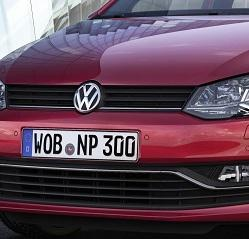

In [132]:
#button to upload photo and display it
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

test_image = None
test_path = None

uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False
)


def upload(change):
    if not uploader.value:
        return

    uploaded_file = next(iter(uploader.value.values()))
    content = uploaded_file['content']
    test_image = Image.open(io.BytesIO(content))
    display(test_image)
    test_image.save('test.jpg')

uploader.observe(upload, names='value')


display(uploader)

In [133]:
test_path = "/content/test.jpg"
print(f"path of test image {test_path}")

path of test image /content/test.jpg


In [134]:
#roboflow ML model used to detect plate: https://universe.roboflow.com/test-pj04p/licenseplate-apu6u/model/1
#detect plate and crop image
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="piM7eEuj3vEZwnMHJyAC"
)

license = CLIENT.infer(test_path, model_id="licenseplate-apu6u/1")
print("License", license)

predictions = license['predictions']
if (len(predictions) > 0):
  prediction = predictions[0]

  x = prediction['x']
  y = prediction['y']
  width = prediction['width']
  height = prediction['height']
  print(f"License position: x={x}, y={y}, width={width}, height={height}")
else:
  print("Cannot determine license position")

License {'time': 0.02842929300004471, 'image': {'width': 249, 'height': 239}, 'predictions': [{'x': 78.5, 'y': 142.5, 'width': 117.0, 'height': 33.0, 'confidence': 0.8667287826538086, 'class': 'plate - v2 2023-10-17 6-21pm', 'class_id': 2, 'detection_id': '689686e8-7f8a-4151-b718-be1609267621'}]}
License position: x=78.5, y=142.5, width=117.0, height=33.0


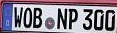

In [135]:
#crop the image based on the detection
from PIL import Image, ImageDraw

test_image = Image.open(test_path)

def crop_image(image, x, y, width, height):
    # Calculate the bottom right corner of the detection box from center position
    left = x - (width / 2)
    upper = y - (height / 2)
    right = x + (width / 2)
    lower = y + (height / 2)
    cropped_test = image.crop((left, upper, right, lower))
    return cropped_test

cropped_test = crop_image(test_image, x, y, width, height)
display(cropped_test)
cropped_test.save('cropped_test.jpg')

cropped_path = "/content/cropped_test.jpg"

In [136]:
#roboflow ML model used to determine license plate numbers: https://universe.roboflow.com/franz-bpzvh/license-ocr-qqq6v/model/1
#can switch to https://universe.roboflow.com/anpr-ci0ri/dheeraj/model/2
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="piM7eEuj3vEZwnMHJyAC"
)

license_number = CLIENT.infer(cropped_path, model_id="license-ocr-qqq6v/3")

print("License Plate:", license_number)
license_plate_number = ''
total_confidence = 0

if len(license_number['predictions']) > 0:
  sorted_predictions = sorted(license_number['predictions'], key=lambda k: k['x'])
  for prediction in sorted_predictions:
    license_plate_number += prediction['class']
    total_confidence += prediction['confidence']
    average_confidence = total_confidence / len(sorted_predictions)*100
  print(f"Full license plate number: {license_plate_number}")
  print(f"Average confidence percentage: {average_confidence:.4f}")
else:
  print("Not able to determine car license plate number")

License Plate: {'time': 0.2099927360000038, 'image': {'width': 117, 'height': 33}, 'predictions': [{'x': 99.0, 'y': 20.0, 'width': 10.0, 'height': 22.0, 'confidence': 0.8799598217010498, 'class': '0', 'class_id': 0, 'detection_id': 'a12f5a6e-d13e-413f-902c-0cf697055578'}, {'x': 110.5, 'y': 20.0, 'width': 11.0, 'height': 22.0, 'confidence': 0.8458883166313171, 'class': '0', 'class_id': 0, 'detection_id': '1f5ca750-a369-4682-b218-d8465399422a'}, {'x': 87.5, 'y': 19.5, 'width': 11.0, 'height': 23.0, 'confidence': 0.8272911310195923, 'class': '3', 'class_id': 3, 'detection_id': '2f670161-9160-47f2-b7d2-a7139db83892'}]}
Full license plate number: 300
Average confidence percentage: 85.1046


In [141]:
#roboflow ML model used to classify color: https://universe.roboflow.com/search?q=car+color+model
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://classify.roboflow.com",
    api_key="piM7eEuj3vEZwnMHJyAC"
)

result = CLIENT.infer(test_path, model_id="carcolor-r22ys/2")
print("Result color", result)

if len(result['predictions']) > 0:
  color_confidence = [(color, details['confidence']) for color, details in result['predictions'].items()]
  sorted_colors= sorted(color_confidence, key=lambda x: x[1], reverse=True)
  color = sorted_colors[0][0]
  cconfidence = sorted_colors[0][1]*100
  print(f"Color with the highest confidence: {color} ({cconfidence:.4f})")
else:
  print("Not able to determine car color")
  color = ''

Result color {'time': 0.10543536900001982, 'image': {'width': 239, 'height': 249}, 'predictions': {'Black': {'confidence': 0.08631263673305511}, 'Blue': {'confidence': 0.06612880527973175}, 'Brown': {'confidence': 0.07877682149410248}, 'Crimson': {'confidence': 0.6321831941604614}, 'Gray': {'confidence': 0.08773209154605865}, 'Green': {'confidence': 0.10629469901323318}, 'Orange': {'confidence': 0.0976652130484581}, 'Purple': {'confidence': 0.13436059653759003}, 'Red': {'confidence': 0.12304309010505676}, 'Silver': {'confidence': 0.06762261688709259}, 'White': {'confidence': 0.07630178332328796}, 'Yellow': {'confidence': 0.09702597558498383}}, 'predicted_classes': ['Crimson']}
Color with the highest confidence: Crimson (63.2183)


In [143]:
#roboflow ML model used to classify car model: https://universe.roboflow.com/auca/car_models/
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="piM7eEuj3vEZwnMHJyAC"
)

result = CLIENT.infer(test_path, model_id="car_models/1")

print(result)
predictions = result['predictions']

if len(predictions) > 0:
  prediction = predictions[0]
  make = prediction['class']
  mconfidence = prediction['confidence']*100
  print(f"Make with the highest confidence: {make} ({mconfidence:.4f})")
else:
  print("Not able to determine model car")
  make = ''


{'time': 0.05444033599997056, 'image': {'width': 249, 'height': 239}, 'predictions': []}
Not able to determine model car


In [144]:
#Info on Amber Alert

amber_make = 'Hyundai 2003'
amber_color = 'Crimson'
amber_plate = '4F3339'

'''
amber_make = 'Volswagen'
amber_color = 'black'
amber_plate = '77ZFK8'
'''
'''
amber_make = 'Chevrolet Malibu Sedan 2007'
amber_color = 'Gray'
amber_plate = '78ZFH8'
'''

"\namber_make = 'Chevrolet Malibu Sedan 2007'\namber_color = 'Gray'\namber_plate = '78ZFH8'\n"

In [145]:
#compare and output matching % confidence
'''
0 -> matches
1 -> does not match
2 -> cannot determine
'''
#first check license plate, otherwise do make of car and color
if (average_confidence > 50 and len(license_plate_number) == len(amber_plate)):
  if amber_plate == license_plate_number:
    plate_match = 0
  else:
    plate_match = 1
else:
    plate_match = 2

if(plate_match != 0):
  if (mconfidence > 50 and len(make) > 0):
    if (amber_make == make):
     make_match = 0
    else:
     make_match = 1
  else:
    make_match = 2

  if (cconfidence > 50 and len(color) > 0):
    if (amber_color == color):
     color_match = 0
    else:
     color_match = 1
  else:
     color_match = 2

  matching = make_match + color_match
  prob = mconfidence * cconfidence
  if (matching == 0):
    print(f"{prob:.4f}% confident car make and color match! Could be car is amber alert car")
  elif (matching == 1 or matching == 3):
    print(f"{prob:.4f}% confident car make and color match don't match! It is not likely to be amber alert car")
  elif (matching == 4):
    print("Cannot determine if car matches amber alert car")
  else: # matching == 2
    if(color_match == 0):
       print (f"{cconfidence:.4f}% confident that car color matches, but cannot determine other attributes")
    elif (make_match == 0):
       print (f"{mconfidence:.4f}% confident that car make matches, but cannot determine other attributes")
    else: #make_match == 1 and color_match == 1
      print (f"{prob:.4f}% confident that car make nor color matches, It is not likely to be amber alert car")
else:
  print(f"Plates match! {average_confidence:.4f}% confident car is amber alert car")


63.2183% confident that car color matches, but cannot determine other attributes


Car-model-detection data set got from: https://universe.roboflow.com/mxk/car-model-detection/dataset/1#
Car license plate data sett from:
https://universe.roboflow.com/fc-yaew5/lic-plate-ocr/dataset/2


Potential:
https://www.kaggle.com/code/aslanahmedov/automatic-number-plate-recognition/notebook#8.2-DATA-PREPARATION

# Code based from lab on how to train YOLO in case need to train own ML models


In [ ]:
# Install YOLOv8 from ultralytics
!pip install ultralytics

# Car make dataseet from Roboflow
!curl -L "https://universe.roboflow.com/ds/UC5WbIS3s0?key=zyN5aqK966"> roboflow.zip; unzip roboflow.zip; rm roboflow.zip
#https://universe.roboflow.com/project-sm0jj/car-identification-pvyvi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   3432      0 --:--:-- --:--:-- --:--:--  3433
100  250M  100  250M    0     0  51.2M      0  0:00:04  0:00:04 --:--:-- 54.7M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import os
import shutil
import random

# Set the path to your "export" folder
export_path = "./export"

# Set the path to the new folders (train, val, test)
train_path = "./train"
val_path = "./val"
test_path = "./test"

# Set the split ratios (adjust as needed)
train_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation
test_ratio = 0.1   # 10% for testing

# Create the new folders if they don't exist
os.makedirs(os.path.join(train_path, "images"), exist_ok=True)
os.makedirs(os.path.join(train_path, "labels"), exist_ok=True)
os.makedirs(os.path.join(val_path, "images"), exist_ok=True)
os.makedirs(os.path.join(val_path, "labels"), exist_ok=True)
os.makedirs(os.path.join(test_path, "images"), exist_ok=True)
os.makedirs(os.path.join(test_path, "labels"), exist_ok=True)
# os.makedirs(val_path, exist_ok=True)
# os.makedirs(test_path, exist_ok=True)

# Get the list of image files in the "images" folder
image_folder_path = os.path.join(export_path, "images")
image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.png'))]

# Randomly shuffle the list of image files
random.shuffle(image_files)

# Calculate the number of images for each split
num_images = len(image_files)
num_train = int(train_ratio * num_images)
num_val = int(val_ratio * num_images)
num_test = int(test_ratio * num_images)

# Split the image files
train_images = image_files[:num_train]
val_images = image_files[num_train:num_train + num_val]
test_images = image_files[num_train + num_val:]

# Move the images to their respective folders
for img in train_images:
    shutil.move(os.path.join(image_folder_path, img), os.path.join(os.path.join(train_path, "images"), img))

for img in val_images:
    shutil.move(os.path.join(image_folder_path, img), os.path.join(os.path.join(val_path, "images"), img))

for img in test_images:
    shutil.move(os.path.join(image_folder_path, img), os.path.join(os.path.join(test_path, "images"), img))

# Repeat the same process for the "labels" folder

label_folder_path = os.path.join(export_path, "labels")

# Move the label files to their respective folders
for lbl in train_images:
    lbl = lbl.replace('.jpg', '.txt')
    shutil.move(os.path.join(label_folder_path, lbl), os.path.join(os.path.join(train_path, "labels"), lbl))

for lbl in val_images:
    lbl = lbl.replace('.jpg', '.txt')
    shutil.move(os.path.join(label_folder_path, lbl), os.path.join(os.path.join(val_path, "labels"), lbl))

for lbl in test_images:
    lbl = lbl.replace('.jpg', '.txt')
    shutil.move(os.path.join(label_folder_path, lbl), os.path.join(os.path.join(test_path, "labels"), lbl))



FileNotFoundError: [Errno 2] No such file or directory: './export/images'

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # load a pretrained model

# Use the model
model.train(data="data.yaml", epochs=3)  # train the model
metrics = model.val()  # evaluate model performance on the validation set

In [ ]:
model.val()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Provided class names and mAP scores
class_names = ['biker', 'car', 'pedestrian', 'trafficLight', 'trafficLight-Green', 'trafficLight-GreenLeft', 'trafficLight-Red', 'trafficLight-RedLeft', 'trafficLight-Yellow', 'trafficLight-YellowLeft', 'truck']
map_scores = np.array([0.25673, 0.49796, 0.21227, 0.248, 0.18836, 0.069847, 0.32001, 0.34009, 0.019975, 0, 0.46942])

# Overall metrics
overall_precision = 0.7306617418898251
overall_recall = 0.4009649872960393
overall_map50 = 0.45983270610938426
overall_map50_95 = 0.2384235722121747

# Plotting mAP scores by class
plt.figure(figsize=(14, 7))

# Bar chart for mAP@50
plt.subplot(1, 2, 1)
plt.bar(class_names, map_scores, color='skyblue')
plt.title('mAP Scores by Class')
plt.xlabel('Class')
plt.ylabel('mAP')
plt.xticks(rotation=45, ha="right")

# Adding overall mAP@50 and mAP@50-95 to the plot
plt.subplot(1, 2, 2)
metrics = ['Precision', 'Recall', 'mAP@50', 'mAP@50-95']
values = [overall_precision, overall_recall, overall_map50, overall_map50_95]
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.title('Overall Detection Metrics')
plt.ylabel('Value')

plt.tight_layout()
plt.show()
